## Training and Uploading of the Model



#### We first need to import and potentially install to some libraries

Some libraries like pandas and skearn come pre installed with AI-lab. Check the error message and install the other missing libraries.

In [1]:
import pandas as pd
import numpy as np
from xgboost import plot_importance, plot_tree
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

### Open Configuration


In [2]:
%run ../utils/access_store_ui.ipynb
display(get_access_store_ui('../'))

Output()

Box(children=(Box(children=(Label(value='Configuration Store', layout=Layout(border_bottom='solid 1px', border…

### Exporting Dataset into Pandas

We have download a dataset from Kaggle called 'Store Sales Forecasting Dataset'. Uploaded it into the database and now we are importing it into this notebook.

In [3]:
from exasol.nb_connector.connections import open_pyexasol_connection
    
with open_pyexasol_connection(ai_lab_config, compression=True) as conn:
   sql_train = f'Select * from  {ai_lab_config.db_schema}.TRAIN_TABLE'
   data = conn.export_to_pandas(sql_train)

#### Splitting the data into features (X) and target (y)


In [5]:
X = data.drop(columns=['Sales', 'Row ID', 'Order ID', 'Customer ID', 'Customer Name', 'Product Name', 'Product ID', 'Ship Date', 'Order Date'])
y = data['Sales']

### Create train and test datasets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1696, 444) (425, 444) (1696,) (425,)


### Model Training with XGBoost
We are now executing the training of the model. This may take some time.


In [7]:
model = XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    random_state=42,
    enable_categorical=True
)
model.fit(X_train, y_train,verbose=True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

### Feature Importances Plot


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

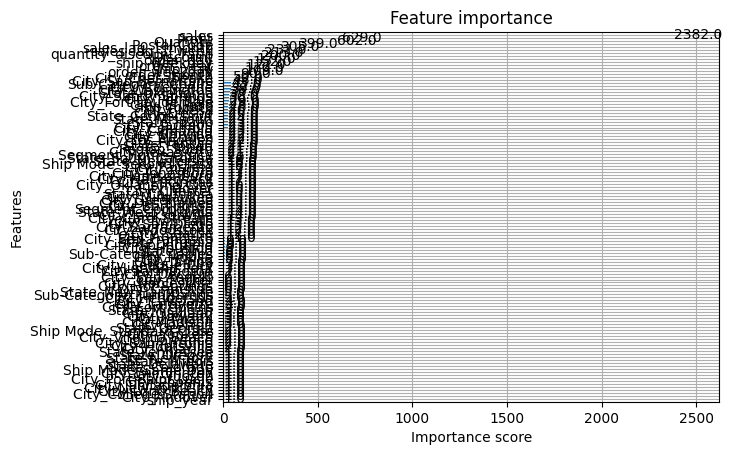

In [13]:
xgb.plot_importance(model, importance_type='weight')  # 'weight' is the number of times a feature is used in a split


### Predicting on the test data and Evaluating the model
We are now predicting with our model on the test dataset and evaluating the results with the target variable of our test dataset.
R² (R-squared) measures how well a model explains the variance in the dependent variable, with values ranging from 0 (no explanation) to 1 (perfect explanation). Values below 0 occur when the model performs worse than a simple mean model,
Our model has a R² value close to 1 which means it can be trusted with the predictions, but it doesn't guarantee a good model, especially in cases of overfitting.

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predictions
y_pred = model.predict(X_test)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

RMSE: 75.48
MAE: 8.37
R²: 0.9814


#### Compare the results to the orignals
With this we can see how our predicted results look like against the real world values.

In [11]:
comparison_df = pd.DataFrame({
    'Actual_Sales': y_test,
    'Predicted_Sales': y_pred
})
print(comparison_df)

      Actual_Sales  Predicted_Sales
1845        94.200        93.134224
1486      1685.880      1664.835571
289         18.840        17.047056
1607        58.248        58.144760
1857         6.984         7.828158
...            ...              ...
1517      4416.174      2925.046387
218        722.352       717.872131
579        308.499       307.921692
2086       483.136       484.147522
351        515.880       516.646362

[425 rows x 2 columns]


### Upload the model into BucketFS

Now that we have trained our model and tested the performance of it against our test dataset. We can now move on and upload it in BucketFS.

In [12]:
import pickle
from exasol.nb_connector.connections import open_bucketfs_connection
from stopwatch import Stopwatch
MODEL_FILE = 'xgb_model.pkl'

# Connect to the BucketFS service
bucket = open_bucketfs_connection(ai_lab_config)

# Serialize the model into a byte-array and upload it to the BucketFS, 
# where it will be saved in the file with the specified name.
bucket.upload(MODEL_FILE, pickle.dumps(model))

print(f"Uploading the model done")

Uploading the model done


## Creating a command for SLC uploading 

Before we start with this cell. We need to take a detour. Go to the [script_languages_container notebooks](../script_languages_container/using_the_script_languages_container_tool.ipynb) and go through all the cells over there. You can see how SLCs are created and customized.
Make sure to use the [Advanced topics](../script_languages_container/advanced.ipynb) notebook because the current SLC does not include the XGBoost package inside and we are adding just that in the advanced topic notebook.
You can execute the cell below once you have created the script_language_release folder in your script_languages_container folder.
Make sure to check that "flavour_path", "bucketfs_name", "bucket_name" and "container_name" have the same values. These are the default values but, you can also modify these. 

In [19]:
from exasol.slc.api.generate_language_activation import generate_language_activation
from exasol.nb_connector.connections import open_pyexasol_connection

result = generate_language_activation(
  flavor_path = "/home/jupyter/notebooks/script_languages_container/script_languages_release/flavors/template-Exasol-all-python-3.10",
  bucketfs_name = 'bfsdefault',
  bucket_name= 'default',
  container_name="test_slc"
)

alter_session = result[0]
print(alter_session)


ALTER SESSION SET SCRIPT_LANGUAGES='PYTHON3=localzmq+protobuf:///bfsdefault/default/test_slc?lang=python#buckets/bfsdefault/default/test_slc/exaudf/exaudfclient';


## Run Forecasting in the Exasol Database
The code connects to an Exasol database, retrieves data from a test table (TEST_TABLE), and uses a user-defined function (UDF) called XGBOOST_PRED to generate predictions. The UDF is defined within the Exasol database and performs the prediction using an XGBoost model. The model's file path (bfs_model_path) is passed as a parameter to the UDF, along with the row ID and the list of feature columns. The UDF emits the prediction results (target column Sales) for each row in the table. The predictions are then fetched and stored in a pandas DataFrame (df_pred). The process is timed using a Stopwatch to measure how long it takes to complete the predictions.

In [18]:

from exasol.nb_connector.connections import open_pyexasol_connection, get_udf_bucket_path
from stopwatch import Stopwatch

target_column = 'Predicted Sales'
bfs_model_path = get_udf_bucket_path(ai_lab_config) + '/xgb_model.pkl'
params = {'schema': ai_lab_config.db_schema, 'test_table': 'TEST_TABLE', 'model_path': bfs_model_path}
sql = 'SELECT * FROM {schema!i}.{test_table!i} LIMIT 1'

stopwatch = Stopwatch()

with open_pyexasol_connection(ai_lab_config, compression=True) as conn:
    conn.execute(alter_session)
    # Get the list of feature columns
    df_tmp = conn.export_to_pandas(query_or_table=sql, query_params=params)
    params['column_names'] = [f'[{c}]' for c in df_tmp.columns]
   
#     # Get the predictions for all rows in the TEST table calling the prediction UDF.
#     # Provide the model path and the row ID in the first two parameters.
    sql = f'SELECT {{schema!q}}.XGBOOST({{model_path!s}},ROWID, {{column_names!r}}) ' \
        f'emits ([{target_column}] FLOAT) FROM {{schema!q}}.{{test_table!q}}'
    df_pred = conn.export_to_pandas(query_or_table=sql, query_params=params)
   
        
print(f"Getting predictions took: {stopwatch}")


Getting predictions took: 4.18s


**Print** the predicted values and **Congratulations!** you have succesfully ran prediction on the Exasol database using Exasol's AI architecture.

In [17]:
print(df_pred)

           Sales
0      15.383313
1     549.579041
2     428.367737
3     613.460083
4     660.339111
...          ...
2116  528.232056
2117   83.554619
2118   24.170292
2119  130.089111
2120   86.779251

[2121 rows x 1 columns]
